# **CS485 & CS584 - Homework 4**



Understanding the decisions made by Graph Neural Networks (GNNs) is crucial for trust, transparency, and model debugging, especially in applications like drug discovery, fraud detection, and social network analysis. GNN explainability helps identify which nodes, edges, or features contribute most to predictions, providing insights into model behavior and potential biases.  

In this Colab, we explore the explainability of GNNs. We first build and train a GNN on the [MUTAG](https://paperswithcode.com/dataset/mutag) dataset using [PyTorch Lightning](https://www.pytorchlightning.ai/). Then, we apply [GNNExplainer](https://arxiv.org/abs/1903.03894) and conduct experiments with [Captum](https://captum.ai/) to achieve GNN explainability.

Now let's get started! This Colab should take 1 hour to complete.

**Note**: Make sure to **restart and run all** before submission, so that the intermediate variables / packages will carry over to the next cell.

### Setup
Let's start by downloading the required packages. You might need to use a GPU for this Colab to run quickly.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**. You can switch to a `T4 GPU` instance to access a free T4 GPU with 16 GB of memory.

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch has version 2.5.1+cu124


Download the necessary packages for PyG, ensuring that your PyTorch version matches the output from the previous cell. In this Colab, we use [PyTorch Lightning](https://www.pytorchlightning.ai/), a widely used deep learning framework that simplifies training loops and improves scalability compared to PyTorch, to train our GNNs. In your future study and research, you may choose either PyTorch or PyTorch Lightning based on your needs and preferences.

In [2]:
torch_version = str(torch.__version__)
pyg_url = f"https://data.pyg.org/whl/torch-{torch_version}.html"

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f {pyg_url}
!pip install torch-geometric pytorch-lightning captum

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


### 1 Load, Check and Preprocess Dataset

See the MUTAG page on [Papers With Code](https://paperswithcode.com/dataset/mutag) and related papers for more information about the dataset.

First, let's start by checking basic information about the dataset and doing some visualizations.

Number of graphs: 188
Number of classes: 2
Number of node features: 7
Number of edge features: 4

Node feature shape: torch.Size([17, 7])
Edge index shape: torch.Size([2, 38])
Is the graph undirected? True


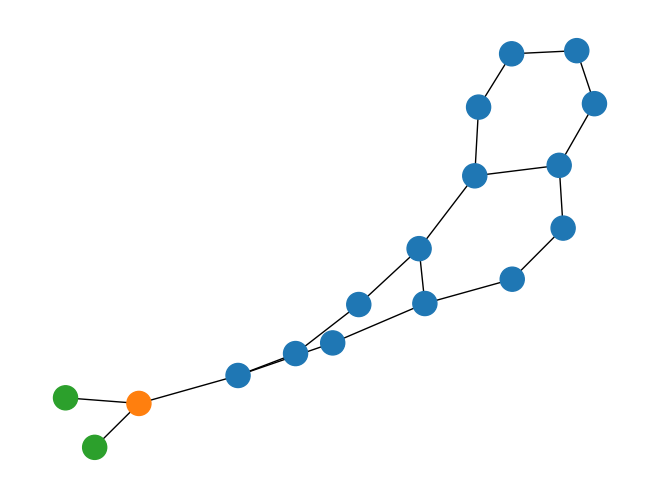

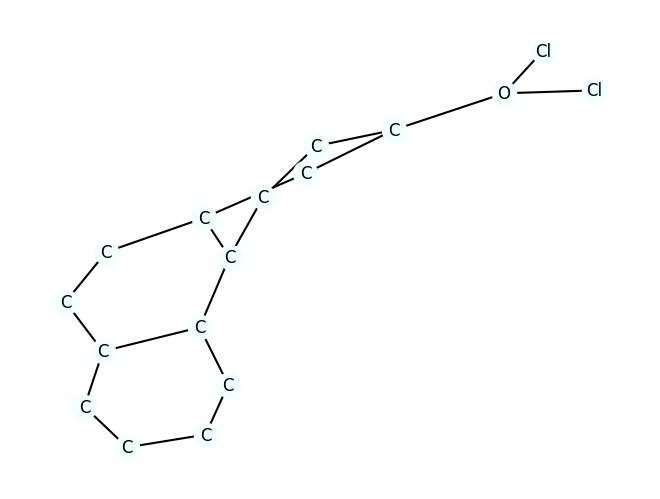

In [3]:
import torch_geometric as ptgeom
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors

from torch_geometric.utils import to_networkx

# Function to visualize a molecule graph
def draw_molecule(g, edge_mask=None, draw_edge_labels=False, ax=None):
    g = g.copy().to_undirected()
    node_labels = {u: data['name'] for u, data in g.nodes(data=True)}
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)

    edge_color = 'black' if edge_mask is None else [edge_mask[(u, v)] for u, v in g.edges()]
    widths = None if edge_mask is None else [x * 10 for x in edge_color]

    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red', ax=ax)

    if ax is None:
        plt.show()

# Convert PyG Data object to NetworkX molecule representation
def to_molecule(data: ptgeom.data.Data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']

    return g

# Define a function to visualize the graph
colors = list(mcolors.TABLEAU_COLORS)
def draw_graph(g: ptgeom.data.Data):
    node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]  # Assign colors based on atom type
    g_nx = ptgeom.utils.to_networkx(g, to_undirected=True)  # Convert to NetworkX
    nx.draw(g_nx, node_color=node_color)
    plt.show()


# Load the MUTAG dataset
mutag = ptgeom.datasets.TUDataset(root='.', name='MUTAG')

# Print dataset statistics
print(f"Number of graphs: {len(mutag)}")
print(f"Number of classes: {mutag.num_classes}")  # Binary (graph-level) classification
print(f"Number of node features: {mutag.num_features}")  # One-hot encoding for node types (atoms)
print(f"Number of edge features: {mutag.num_edge_features}\n")  # One-hot encoding for bond types

# Let us select the first graph in the dataset and check the basic information about the graph
mutag_0 = mutag[0]
print(f"Node feature shape: {mutag_0.x.shape}")
print(f"Edge index shape: {mutag_0.edge_index.shape}")
print(f"Is the graph undirected? {ptgeom.utils.is_undirected(mutag_0.edge_index)}")

# Draw the first graph in MUTAG and visualize the first molecule in MUTAG
draw_graph(mutag_0)
draw_molecule(to_molecule(mutag_0))


Then, let us prepare the data loader for MUTAG dataset. Data Loaders automate the batching process, enabling efficient training by grouping multiple graphs or subgraphs into mini-batches. This improves memory usage, accelerates training, and ensures consistency in data handling across different models.


In [4]:
import torch_scatter
import torch_geometric as ptgeom
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets using stratified split based on class labels
train_idx, test_idx = train_test_split(
    range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25
)

# Create DataLoaders for training and testing;
# Sometimes you may also create a `validation_loader` if a validation set is available or created.
train_loader = ptgeom.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = ptgeom.loader.DataLoader(mutag[test_idx], batch_size=32)

# Inspect the first batch
batch = next(iter(train_loader))

# Batch structure: all subgraphs combined as a single disconnected graph
print(f"Node feature shape: {batch.x.shape}")  # All nodes from 32 graphs combined
print(f"Graph labels shape: {batch.y.shape}")  # One label per graph
print(f"Edge index shape: {batch.edge_index.shape}")  # Edge connections

# Perform graph-level aggregation using torch_scatter
scatter_sum_result = torch_scatter.scatter_sum(batch.x, batch.batch, dim=0)
print(f"Graph-level sum aggregation shape: {scatter_sum_result.shape}")

# Alternative approach using PyG's built-in pooling layer
mean_pool_result = ptgeom.nn.global_mean_pool(batch.x, batch.batch)
print(f"Graph-level mean pooling shape: {mean_pool_result.shape}")


Node feature shape: torch.Size([584, 7])
Graph labels shape: torch.Size([32])
Edge index shape: torch.Size([2, 1296])
Graph-level sum aggregation shape: torch.Size([32, 7])
Graph-level mean pooling shape: torch.Size([32, 7])


### 2 Build a GNN model

In Homework 3, we trained a GNN using native PyTorch, where we manually implemented training, validation, and test functions.

In this Homework, we introduce PyTorch Lightning, a deep learning framework built on PyTorch that simplifies model training by automating boilerplate code, making the process more structured and efficient. Both PyTorch and PyTorch Lightning are widely used in deep learning.

PyTorch Lightning eliminates the need for manually writing training loops by providing built-in functions such as `training_step`, `validation_step`, and `configure_optimizers`. It also offers advanced features like automatic checkpointing, multi-GPU training, and logging, allowing researchers to focus on model design rather than low-level implementation details.  If you're new to PyTorch Lightning and want to learn the basics, check out a [5-minute intro](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

Now, let us build up a GNN model and train it using PyTorch Lightning.

In [5]:
import torch
import torch.nn.functional as F
import torch_geometric as ptgeom
import pytorch_lightning as ptlight
from torchmetrics.classification import Accuracy

# Model architecture: GCNConv → GCNConv → Graph Pooling → Dropout → Linear
class MUTAGClassifier(ptlight.LightningModule):
    def __init__(self):
        super().__init__()
        self.gc1 = ptgeom.nn.GCNConv(7, 256)
        self.gc2 = ptgeom.nn.GCNConv(256, 256)
        self.linear = torch.nn.Linear(256, 1)

        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')

    def forward(self, x, edge_index=None, batch=None, edge_weight=None):
        # "edge_weight" is used for explainability, not during training
        if edge_index is None:
            x, edge_index, batch = x.x, x.edge_index, x.batch
        x = F.relu(self.gc1(x, edge_index, edge_weight))
        x = F.relu(self.gc2(x, edge_index, edge_weight))
        x = ptgeom.nn.global_mean_pool(x, batch)
        x = F.dropout(x, training=self.training)
        return self.linear(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, _):
        y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
        loss = F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float())
        acc = self.train_acc(y_hat, batch.y.unsqueeze(1))

        self.log("train_loss", loss)
        self.log("train_accuracy", acc, prog_bar=True, batch_size=32)
        return loss

    def validation_step(self, batch, _):
        y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
        acc = self.val_acc(y_hat, batch.y.unsqueeze(1))

        self.log("val_accuracy", acc, prog_bar=True, batch_size=32)


# Instantiate the classifier
gnn = MUTAGClassifier()

# Save checkpoints every 50 epochs
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1
)

# Define the trainer and train the model
trainer = ptlight.Trainer(max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(gnn, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | gc1       | GCNConv        | 2.0 K  | train
1 | gc2       | GCNConv        | 65.8 K | train
2 | linear    | Linear         | 257    | train
3 | train_acc | BinaryAccuracy | 0      | train
4 | val_acc   | BinaryAccuracy | 0      | train
-----------------------------------------------------
68.1 K    Trainable params
0         Non-trainable params
68.1 K    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### 3 Explainability Study

#### **Question 1: Explainability with GNNExplainer. (20 points)**

GNNExplainer identifies a compact subgraph $G_S$ and a subset of important node features $X_S$ that are crucial for a Graph Neural Network's (GNN) prediction. The model formulates this as an **optimization problem** that maximizes the mutual information between the GNN's prediction and the selected subgraph structure and features:

$$
\max_{G_S, X_S} MI(Y, (G_S, X_S)) = H(Y) - H(Y | G = G_S, X = X_S)
$$

where $MI(Y, (G_S, X_S))$ quantifies the impact of the subgraph and selected features on the predicted label $Y$, and $H(Y)$ is the entropy of the predicted distribution. This optimization problem is solved by learning a **soft mask** over the graph's adjacency matrix $A_S$ and node features, allowing the model to identify the most influential components for the GNN's decision.

The explanation is derived by minimizing the **conditional entropy**:

$$
H(Y | G = G_S, X = X_S) = - \mathbb{E}_{Y | G_S, X_S} [\log P_{\Phi}(Y | G_S, X_S)]
$$

where $P_{\Phi}(Y | G_S, X_S)$ is the GNN's predicted probability given the selected subgraph and features. A **graph mask** $M$ is applied using a sigmoid function $\sigma(M)$ to approximate discrete selections in a differentiable manner:

$$
A_S = A_C \odot \sigma(M)
$$

where $A_C$ is the original adjacency matrix, $\sigma(M)$ is the learned edge importance mask, and $\odot$ represents element-wise multiplication.

This framework enables **GNNExplainer** to generate **interpretable** and **task-specific** explanations for various GNN-based predictions, including **node classification, link prediction, and graph classification**.

---

Now let us use the GNNExplainer to extract important subgraphs. Given a trained **GNN** and a test graph $G = (V, E)$, GNNExplainer follows these steps:

1. **Generate Explanation via Edge Masking**  
   The **edge importance mask** $e$ is obtained after optimization:

   $$
   e = \sigma(M) \in [0,1]^{|E|}
   $$

   where each $e_i$ represents the learned importance of edge $e_i$.

2. **Thresholding to Select Important Edges**  
   Edges with importance above a predefined threshold $\tau$ are selected:

   $$
   E' = \{ e_i \in E \mid e_i > \tau \}
   $$

   where $\tau$ is typically set to **0.96** to filter the most significant edges.

3. **Constructing the Explanation Subgraph**  
   The **new subgraph** $G_S = (V_S, E_S)$ is formed:

   $$
   V_S = \{ v_i \in V \mid \exists e_{ij} \in E' \}
   $$

   ensuring that only nodes connected by important edges remain.

4. **Graph Post-processing**  
   - Convert the graph to an undirected form:

     $$
     E_S^{\text{undirected}} = \{(i, j) \mid (i, j) \in E_S \lor (j, i) \in E_S \}
     $$

   - Remove **isolated nodes**:

     $$
     V_S' = \{ v_i \in V_S \mid \exists e_{ij} \in E_S^{\text{undirected}} \}
     $$

   ensuring the final subgraph $G_S' = (V_S', E_S^{\text{undirected}})$ is well-connected and meaningful.


---

GNNExplainer is a simple method to search for instance-level explanations on a trained GNN. It optimizes for the smallest feature and edge masks that do not vary the prediction of the trained model. See the full explanation in the [original paper](https://arxiv.org/pdf/1903.03894.pdf). You do not need to implement GNNExplainer, as we use the [GNNExplainer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html) provided by PyG.

Extracted subgraph details: Data(x=[15, 7], edge_index=[2, 22], y=[1])


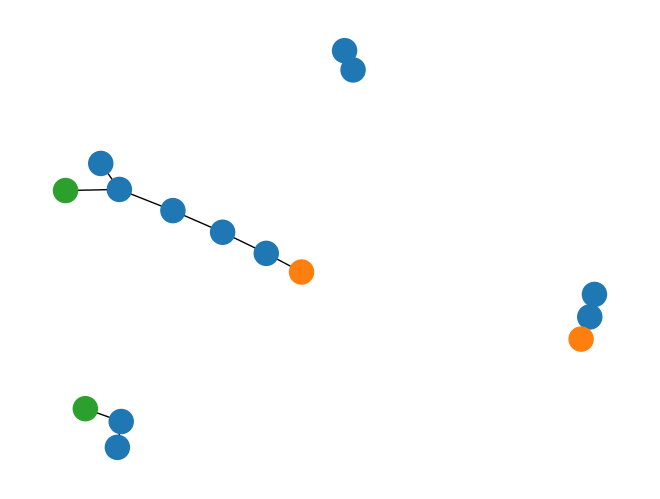

In [6]:
import torch
import torch_geometric as ptgeom
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data

def generate_gnn_explanation(gnn, test_graph, threshold=0.96):
    # Generates an explanation for a given graph using GNNExplainer.
    # Returns the extracted subgraph containing the most relevant edges and nodes.

    # Initialize GNNExplainer
    explainer = Explainer(
        model=gnn,
        algorithm=GNNExplainer(epochs=300),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw',
        ),
    )

    # 1. Generate explanation using the GNNExplainer
    explanation = explainer(test_graph.x, test_graph.edge_index, batch=test_graph.batch)

    # 2. Extract edge importance mask (edge_mask scores the importance of each edge)
    edge_mask = explanation.edge_mask  # Values range from 0 to 1

    # 3. Select important edges based on the threshold
    important_edges = test_graph.edge_index[:, edge_mask > threshold]

    # 4. Construct the subgraph from the test_graph
    explained_graph = Data(
        x=test_graph.x,
        edge_index=important_edges,
        y=test_graph.y  # Retain graph label
    )

    # 5. Convert to undirected and remove isolated nodes
    explained_graph = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explained_graph))

    return explained_graph


# Move model to device and set to evaluation mode
gnn = gnn.to(device)
gnn.eval()

# Select a test graph
idx = 0
test_graph = mutag[test_idx[idx]].to(device)

# Extract an important subgraph
important_subgraph = generate_gnn_explanation(gnn, test_graph)
print(f"Extracted subgraph details: {important_subgraph}")

# Visualize the extracted subgraph
draw_graph(important_subgraph)


#### **Question 2: Explainability with Integrated Gradients. (15 points)**

Instead of using a custom-made explainer, we can also try using a "standard" one. For example, here we use the implementation of integrated gradients provided by [Captum](https://captum.ai/docs/introduction). This will integrate a "saliency vector" moving from a graph with no connectivity to our actual graph.

Integrated Gradients (IG) provides an attribution method for explainability by computing the importance of each edge in a graph. Given a trained Graph Neural Network (GNN) and a test graph $G = (V, E)$, IG integrates gradients from a baseline graph with no edges to the actual graph, capturing the contribution of each edge to the model's prediction.

For a given edge mask $\alpha \cdot E$ where $\alpha \in [0,1]$, IG computes the importance of each edge by integrating gradients along a continuous path from a **baseline graph** (disconnected nodes, $\alpha = 0$) to the actual graph ($\alpha = 1$):

$$
\text{IG}(E_i) = (E_i - E_i^{(0)}) \times \int_{\alpha=0}^{1} \frac{\partial f_{\theta}(X, \alpha E)}{\partial E_i} d\alpha
$$

where:
- $E_i$ is an edge in the graph.
- $E_i^{(0)}$ represents the baseline (no connectivity).
- $f_{\theta}(X, E)$ is the GNN's output given node features $X$ and edge set $E$.
- $\frac{\partial f_{\theta}(X, \alpha E)}{\partial E_i}$ is the gradient of the GNN's output with respect to edge $E_i$.
- The integral is approximated by **Riemann summation** over discrete steps.

After computing IG attributions for all edges, we select the most relevant ones, similar to the approach used in GNNExplainer. The overall process can be described as follows:
1. Define a forward function for the GNN with an edge mask.
2. Apply Integrated Gradients (IG) to compute edge importance.
3. Extract the most important subgraph using the computed mask.
4. Convert the subgraph to an undirected format and remove isolated nodes.

More details are provided in [Captum IntegratedGradients Document](https://captum.ai/docs/extension/integrated_gradients).

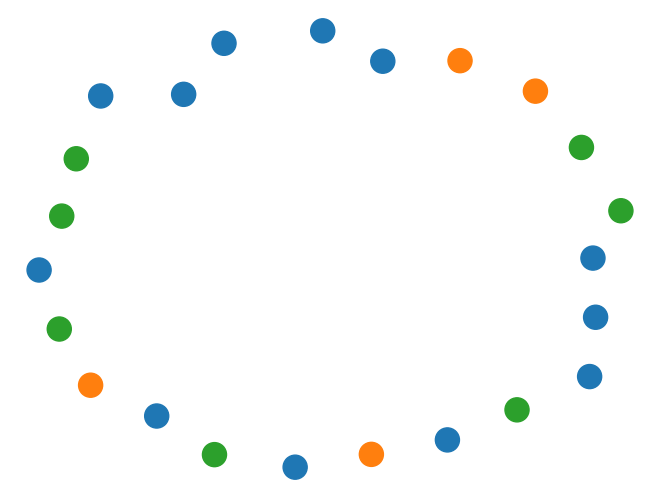

In [7]:
import torch
import torch_geometric as ptgeom
from captum.attr import IntegratedGradients
from torch_geometric.data import Data

def integrated_gradients_explanation(threshold=0.1):
    # Need to use Integrated Gradients to extract an important subgraph.
    # Args: threshold (float): Edge importance threshold.
    # Returns: ptgeom.data.Data: Extracted subgraph.
    # You do not need to implement Integrated Gradients.

    # Function for forward pass with an edge mask
    batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64, device=device)

    def model_forward(edge_mask):
        return gnn(test_graph.x, test_graph.edge_index, batch_idx, edge_weight=edge_mask[0])

    explanation = ptgeom.data.Data().to(device)

    # 1. Initialize the edge mask
    edge_mask = torch.ones(test_graph.edge_index.shape[1], requires_grad=True, device=device)

    # 2. Compute attributions using Integrated Gradients
    ig = IntegratedGradients(model_forward)

    # Handle potential error if edge_attr is empty
    try:
        attributions = ig.attribute(edge_mask, target=test_graph.y, n_steps=50)
    except IndexError:
        # If IndexError occurs, return a subgraph with no edges
        explanation.edge_index = torch.empty(2, 0, dtype=torch.long, device=device)
        explanation.x = test_graph.x
        explanation.y = test_graph.y
        return explanation

    # 3. Extract the important subgraph based on the learned mask from the test_graph
    important_edges = attributions.abs() > threshold
    explanation.edge_index = test_graph.edge_index[:, important_edges]
    explanation.x = test_graph.x
    explanation.y = test_graph.y

    # 4. Convert to undirected and remove isolated nodes
    explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))

    return explanation


# Extract an important subgraph and visualize
important_subgraph = integrated_gradients_explanation()
draw_graph(important_subgraph)

#### **Question 3: TracIn: Influence Estimation for GNN Explainability. (15 points)**

[TracIn](https://research.google/blog/tracin-a-simple-method-to-estimate-training-data-influence/) is an influence estimation method that identifies **which training examples have the most impact on a model's prediction** for a given test sample. Unlike gradient-based explainability techniques like **GNNExplainer** or **Integrated Gradients**, TracIn measures **influence via gradient similarity** across different training checkpoints. The core idea is that if two data points **share similar gradients**, one significantly influences the other's prediction.

Mathematically, for a test graph $G_{\text{test}}$, the influence of a training graph $G_i$ is computed as the **dot product of their gradients** at multiple model checkpoints:

$$
\text{Influence}(G_{\text{test}}, G_i) = \sum_{k} \langle \nabla_{\theta} f_{\theta_k}(G_{\text{test}}), \nabla_{\theta} f_{\theta_k}(G_i) \rangle
$$

where:
- $f_{\theta_k}(G)$ is the model output at checkpoint $k$.
- $\nabla_{\theta} f_{\theta_k}(G)$ is the gradient of the model's output w.r.t. its parameters $\theta$.
- $\langle \cdot, \cdot \rangle$ represents the inner product, quantifying alignment between gradients.




A **high influence score** means the training graph **positively impacts** the test prediction, while a **negative score** suggests it acts as an "opponent" (reducing confidence in the prediction). By analyzing TracIn scores, we can interpret **which training graphs contribute most to a GNN's decision**, offering insights into the model's learning process.


<ipython-input-8-c544ee0177ad>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Test Graph Label: tensor([1], device='cuda:0')
Test Graph Prediction: -1.0
Proponent Graph Label: tensor([0])
Proponent Graph Prediction: -1.0
Opponent Graph Label: tensor([1])
Opponent Graph Prediction: 1.0


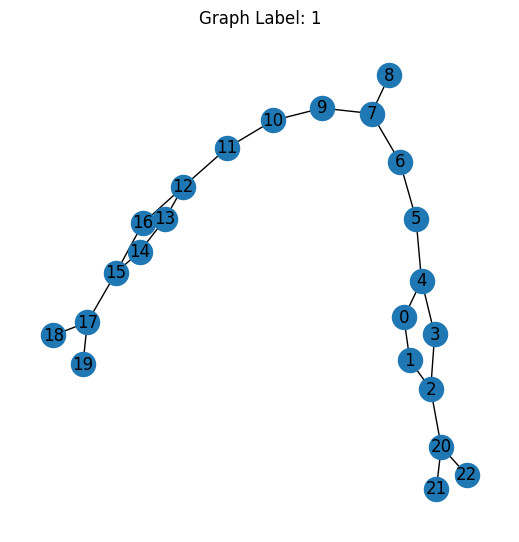

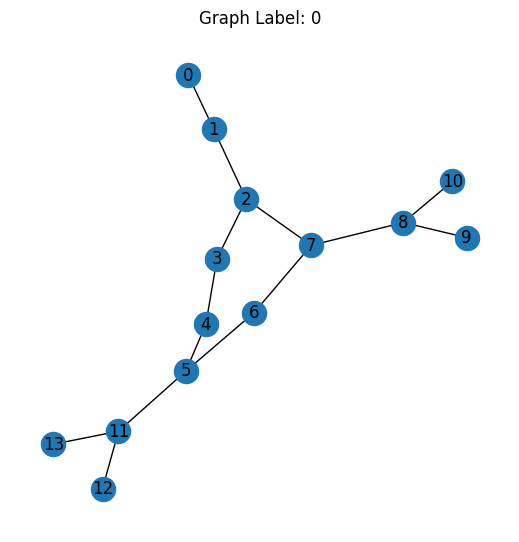

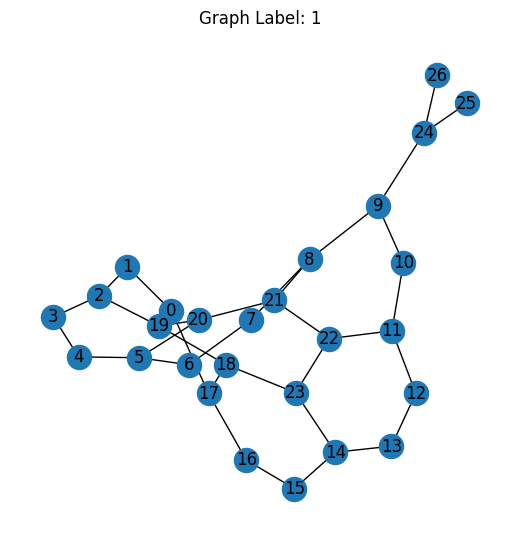

In [8]:
import torch
import matplotlib.pyplot as plt
import torch_geometric as ptgeom
import networkx as nx


def compute_gradient(gnn, graph, checkpoints):
    params = gnn.linear.weight.shape[1]
    gradients = torch.zeros((len(checkpoints), params), device=device)

    for k, checkpoint_path in enumerate(checkpoints):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        gnn.load_state_dict(checkpoint['state_dict'])
        gnn.eval()

        y = gnn(graph.x.to(device), graph.edge_index.to(device))
        gradients[k] = torch.autograd.grad(y, gnn.linear.weight, retain_graph=True)[0].cpu()

    return gradients

def compute_graph_influence(gnn, test_graph, train_graphs, checkpoints, top_k=1):
    proponents = torch.tensor([], dtype=torch.int64)
    opponents = torch.tensor([], dtype=torch.int64)

    test_gradients = compute_gradient(gnn, test_graph.to(device), checkpoints)
    train_gradients = torch.stack([compute_gradient(gnn, graph.to(device), checkpoints) for graph in train_graphs])

    similarity_scores = []
    for i in range(len(checkpoints)):
        checkpoint_similarity = torch.nn.functional.cosine_similarity(test_gradients[i], train_gradients[:, i])
        similarity_scores.append(checkpoint_similarity)

    similarity_scores = torch.stack(similarity_scores).mean(dim=0)

    proponents = torch.topk(similarity_scores, k=top_k).indices
    opponents = torch.topk(similarity_scores, k=top_k, largest=False).indices

    return proponents, opponents

def draw_graph(graph):
    G = nx.Graph()
    G.add_edges_from(graph.edge_index.t().tolist())
    nx.draw(G, with_labels=True)
    plt.title(f"Graph Label: {graph.y.item()}")

# Load model checkpoints
checkpoints = ['checkpoints/gnn-epoch=49.ckpt', 'checkpoints/gnn-epoch=99.ckpt']

# Select a test graph and training graphs
idx = 0
test_graph = mutag[test_idx[idx]]
train_graphs = mutag[train_idx]

# Compute the most and least influential graphs
proponents, opponents = compute_graph_influence(gnn, test_graph, train_graphs, checkpoints)

# Visualize the test graph
plt.figure(figsize=(5,5))
draw_graph(test_graph)
print(f"Test Graph Label: {test_graph.y}")
print(f"Test Graph Prediction: {gnn(test_graph.x.to(device), test_graph.edge_index.to(device)).sign().item()}")

# Visualize the most influential training graphs
for i in proponents:
    plt.figure(figsize=(5,5))
    draw_graph(train_graphs[i])
    print(f"Proponent Graph Label: {train_graphs[i].y}")
    print(f"Proponent Graph Prediction: {gnn(train_graphs[i].x.to(device), train_graphs[i].edge_index.to(device)).sign().item()}")

# Visualize the least influential training graphs
for i in opponents:
    plt.figure(figsize=(5,5))
    draw_graph(train_graphs[i])
    print(f"Opponent Graph Label: {train_graphs[i].y}")
    print(f"Opponent Graph Prediction: {gnn(train_graphs[i].x.to(device), train_graphs[i].edge_index.to(device)).sign().item()}")

# Show all plots
plt.show()
